<h3> CNN_cifar10 </h3>

<h4> without Image Augmentation </h4>

codes from below source are used in this casesetudy

---



https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb

In [1]:
import keras
!pip install scipy==1.1.0

from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras import models, layers
from keras.models import Model
from keras.layers import BatchNormalization, Activation, Flatten
from keras.optimizers import Adam
from matplotlib import pyplot
#from scipy.misc import toimage
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import optimizers
from tensorflow import keras
from keras import backend as k
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Hyperparameters
batch_size = 32
num_classes = 10
#epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 6s 0us/step


In [5]:
X_train.shape

(50000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

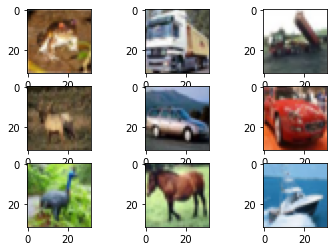

In [7]:
from matplotlib import pyplot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X_train[i])
# show the figure
pyplot.show()

In [0]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    
    )
datagen.fit(X_train,augment=True, rounds=3)

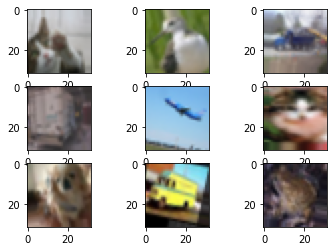

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# see example augmentation images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [10]:
#reshape into images

X_train = X_train.reshape(X_train.shape[0], img_height, img_width, channel)
X_test = X_test.reshape(X_test.shape[0], img_height, img_width, channel)
input_shape = (img_height, img_width, 1)
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
#convert integers to float; normalise and center the mean
import numpy as np
X_train=X_train.astype("float32")  
X_test=X_test.astype("float32")
mean=np.mean(X_train)
std=np.std(X_train)
X_test=(X_test-mean)/std
X_train=(X_train-mean)/std

In [0]:
# plotting epoch vs accuracy
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [0]:
# Dense Block
def denseblock(input, num_filter = 12):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #if dropout_rate>0:
            #Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    #if dropout_rate>0:
         #Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    #flat = layers.Flatten()(AvgPooling)
    #output = layers.Dense(num_classes, activation='softmax')(flat)
    #replcaing Dense layer by conv layer
    #http://cs231n.github.io/convolutional-networks/#convert
    conv_layer = layers.Conv2D(num_classes, (1,1), use_bias=False ,padding='same')(AvgPooling)
    last = layers.GlobalMaxPooling2D()(conv_layer)   #https://www.researchgate.net/post/Differences_between_Global_Max_Pooling_and_Global_Average_pooling
    output = layers.Activation('softmax')(last)
    return output

In [0]:
num_filter = 12
#dropout_rate = 0.2
l = 40

reg=l2(1e-4)

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), activation = 'relu', kernel_initializer = 'he_normal' , kernel_regularizer =reg , use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter)
First_Transition = transition(First_Block, num_filter)

Second_Block = denseblock(First_Transition, num_filter)
Second_Transition = transition(Second_Block, num_filter)

Third_Block = denseblock(Second_Transition, num_filter)
Third_Transition = transition(Third_Block, num_filter)

Last_Block = denseblock(Third_Transition,  num_filter)
output = output_layer(Last_Block)

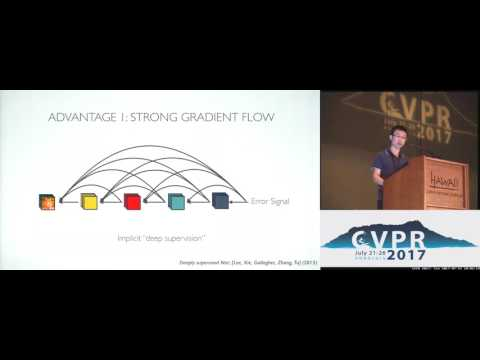

In [0]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [32]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_496 (Conv2D)             (None, 32, 32, 12)   324         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_493 (BatchN (None, 32, 32, 12)   48          conv2d_496[0][0]                 
__________________________________________________________________________________________________
activation_496 (Activation)     (None, 32, 32, 12)   0           batch_normalization_493[0][0]    
____________________________________________________________________________________________

In [0]:
# determine Loss function and Optimizer
#opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [0]:
# patient early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [0]:
# ModelCheckpoint
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('DNST_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

<h3> Training without Image augmentation </h3>

In [37]:
# train without image augmentation
history = model.fit(X_train, y_train, batch_size=32, epochs=300, validation_data=(X_test, y_test), callbacks=[es,mc])

Train on 50000 samples, validate on 10000 samples
Epoch 1/300
50000/50000 [==============================] - 668s 13ms/step - loss: 1.5303 - accuracy: 0.4367 - val_loss: 1.6109 - val_accuracy: 0.4477
Epoch 2/300


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


50000/50000 [==============================] - 655s 13ms/step - loss: 1.1288 - accuracy: 0.5941 - val_loss: 1.0419 - val_accuracy: 0.6278
Epoch 3/300
50000/50000 [==============================] - 655s 13ms/step - loss: 0.9377 - accuracy: 0.6672 - val_loss: 1.0300 - val_accuracy: 0.6415
Epoch 4/300
50000/50000 [==============================] - 654s 13ms/step - loss: 0.8157 - accuracy: 0.7113 - val_loss: 0.9225 - val_accuracy: 0.6843
Epoch 5/300
50000/50000 [==============================] - 654s 13ms/step - loss: 0.7165 - accuracy: 0.7480 - val_loss: 0.8278 - val_accuracy: 0.7172
Epoch 6/300
50000/50000 [==============================] - 654s 13ms/step - loss: 0.6391 - accuracy: 0.7757 - val_loss: 0.8180 - val_accuracy: 0.7244
Epoch 7/300
50000/50000 [==============================] - 653s 13ms/step - loss: 0.5789 - accuracy: 0.7969 - val_loss: 0.7024 - val_accuracy: 0.7622
Epoch 8/300
50000/50000 [==============================] - 652s 13ms/step - loss: 0.5239 - accuracy: 0.8184 - va

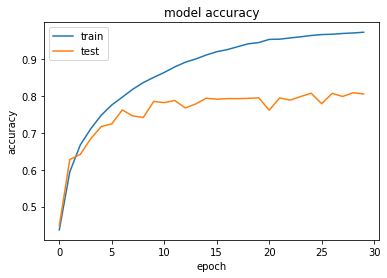

In [40]:
plothist(history)

In [41]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 25s 3ms/step
Test loss: 0.9062438956022263
Test accuracy: 0.8055999875068665


In [42]:
# Save the trained weights in to .h5 format
model.save("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


Summary:
training wihtout image augmentation, have got accuracy :80.13%